In this notebook, we are going to calculate transaction count, aggregate it to hourly data and train an estimator to predict Tx count.

In [1]:
import requests
import traceback
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import numpy as np

## Import data from files

In [2]:
# This function reads data from file
# extracts necessary columns for tx count calculation
# drops remaining block info to reduce memory consumption
def load_df_from_file(file_name):
    dataFile = open(file_name)
    raw =  json.loads(dataFile.read())
    dataFile.close()
    df = pd.DataFrame(raw)
    # extract height from header
    df['height'] = df['header'].apply(lambda row: row['height'])
    # extract timestamp from header
    df['timestamp'] =  df['header'].apply(lambda header: header['timestamp'])
    # extract number of kernels from kernels
    df['n_kernels'] = df['kernels'].apply(lambda entry : len(entry))
    # extract features from kernels
    df['features']  = df['kernels'].apply(lambda kernels : [kernel['features'] for kernel in kernels ])
    df.set_index(pd.to_datetime(df['timestamp']),inplace = True)
    return df[['height','n_kernels','features']]

Download and extract all the files from releases section before running next step

In [3]:
df = pd.concat([
    load_df_from_file('grinblockdata-1-100000.json'),
    load_df_from_file('grinblockdata-100001-200000.json'),
    load_df_from_file('grinblockdata-200001-300000.json'),
    load_df_from_file('grinblockdata-300001-400000.json'),
    load_df_from_file('grinblockdata-400001-500000.json'),
    load_df_from_file('grinblockdata-500001-600000.json'),
    load_df_from_file('grinblockdata-600001-700000.json'),
    load_df_from_file('grinblockdata-700001-800000.json'),
    load_df_from_file('grinblockdata-800001-900000.json'),
    load_df_from_file('grinblockdata-900001-1000000.json'),
    load_df_from_file('grinblockdata-1000001-1100000.json'),
    load_df_from_file('grinblockdata-1100001-1200000.json'),
    load_df_from_file('grinblockdata-1200001-1300000.json'),
    load_df_from_file('grinblockdata-1300001-1400000.json'),
    load_df_from_file('grinblockdata-1400001-1500000.json'),
    load_df_from_file('grinblockdata-1500001-1600000.json'),
    load_df_from_file('grinblockdata-1600001-1700000.json'),
    load_df_from_file('grinblockdata-1700001-1800000.json'),
])

In [4]:
df

,height,n_kernels,features
timestamp,,,
2019-01-15 17:38:05+00:00,1,1,[Coinbase]
2019-01-15 17:38:57+00:00,2,1,[Coinbase]
2019-01-15 17:54:47+00:00,3,1,[Coinbase]
2019-01-15 17:54:52+00:00,4,1,[Coinbase]
2019-01-15 18:17:09+00:00,5,1,[Coinbase]
...,...,...,...
2022-06-23 09:58:55+00:00,1799996,2,"[Plain, Coinbase]"
2022-06-23 09:59:00+00:00,1799997,1,[Coinbase]
2022-06-23 09:59:22+00:00,1799998,1,[Coinbase]


## Calculate transaction counts

To determine transaction count for each block, we need number of kernels, since each block has a coinbase we need to drop 1 from number of kernels

### Check if every block has a single coinbase kernel

In [5]:
#To check if each block has only one coinbase kernel define a function
def f_check_Coinbase_is_single(features):
    (el,count) = np.unique(features,return_counts=True)
    d = dict(zip(el,count))
    return d['Coinbase'] == 1

In [6]:
f_check_Coinbase_is_single(['Coinbase', 'Plain', 'Plain'])

True

Apply function to features_column

In [7]:
check_array = df['features'].apply(f_check_Coinbase_is_single)
check_array

timestamp
2019-01-15 17:38:05+00:00    True
2019-01-15 17:38:57+00:00    True
2019-01-15 17:54:47+00:00    True
2019-01-15 17:54:52+00:00    True
2019-01-15 18:17:09+00:00    True
                             ... 
2022-06-23 09:58:55+00:00    True
2022-06-23 09:59:00+00:00    True
2022-06-23 09:59:22+00:00    True
2022-06-23 10:00:29+00:00    True
2022-06-23 10:01:56+00:00    True
Name: features, Length: 1800000, dtype: bool

In [8]:
# Is all elements in check_array True?
check_array.all()

True

Now we can drop 1 for Coinbase from n_kernels to calculate tx count

### Calculate tx_count

In [9]:
df['tx_count'] = df['n_kernels'] -1
df['tx_count']


timestamp
2019-01-15 17:38:05+00:00    0
2019-01-15 17:38:57+00:00    0
2019-01-15 17:54:47+00:00    0
2019-01-15 17:54:52+00:00    0
2019-01-15 18:17:09+00:00    0
                            ..
2022-06-23 09:58:55+00:00    1
2022-06-23 09:59:00+00:00    0
2022-06-23 09:59:22+00:00    0
2022-06-23 10:00:29+00:00    0
2022-06-23 10:01:56+00:00    2
Name: tx_count, Length: 1800000, dtype: int64

Let's calculate frequency of tx counts

In [10]:
[count,frequency] = np.unique(df['tx_count'],return_counts=True)
for e in zip(count,frequency):
    print(f"number of blocks with {e[0]:2} tx: {e[1]:7} ({e[1]/df['height'].max()*100:4.1f} %)")

number of blocks with  0 tx: 1142810 (63.5 %)
number of blocks with  1 tx:  324768 (18.0 %)
number of blocks with  2 tx:  136024 ( 7.6 %)
number of blocks with  3 tx:   67098 ( 3.7 %)
number of blocks with  4 tx:   37124 ( 2.1 %)
number of blocks with  5 tx:   23800 ( 1.3 %)
number of blocks with  6 tx:   15768 ( 0.9 %)
number of blocks with  7 tx:   11199 ( 0.6 %)
number of blocks with  8 tx:    8140 ( 0.5 %)
number of blocks with  9 tx:    5990 ( 0.3 %)
number of blocks with 10 tx:    4587 ( 0.3 %)
number of blocks with 11 tx:    3657 ( 0.2 %)
number of blocks with 12 tx:    2979 ( 0.2 %)
number of blocks with 13 tx:    2418 ( 0.1 %)
number of blocks with 14 tx:    1941 ( 0.1 %)
number of blocks with 15 tx:    1528 ( 0.1 %)
number of blocks with 16 tx:    1316 ( 0.1 %)
number of blocks with 17 tx:    1088 ( 0.1 %)
number of blocks with 18 tx:     909 ( 0.1 %)
number of blocks with 19 tx:     819 ( 0.0 %)
number of blocks with 20 tx:     674 ( 0.0 %)
number of blocks with 21 tx:     5

### Aggregate to hourly data

In [11]:
df_hourly = df.resample('1H', ).agg(
    OrderedDict([
        ('height', 'last'),
        ('tx_count', 'sum')        
    ]))
df_hourly

,height,tx_count
timestamp,,
2019-01-15 17:00:00+00:00,4.0,0
2019-01-15 18:00:00+00:00,23.0,0
2019-01-15 19:00:00+00:00,55.0,0
2019-01-15 20:00:00+00:00,92.0,0
2019-01-15 21:00:00+00:00,151.0,0
...,...,...
2022-06-23 06:00:00+00:00,1799816.0,8
2022-06-23 07:00:00+00:00,1799878.0,7
2022-06-23 08:00:00+00:00,1799937.0,4


## Tx count prediction

We will use hour as an input so let's extract it as a column.

In [12]:
df_hourly['hour'] =  df_hourly.index.hour
df_hourly

,height,tx_count,hour
timestamp,,,
2019-01-15 17:00:00+00:00,4.0,0,17
2019-01-15 18:00:00+00:00,23.0,0,18
2019-01-15 19:00:00+00:00,55.0,0,19
2019-01-15 20:00:00+00:00,92.0,0,20
2019-01-15 21:00:00+00:00,151.0,0,21
...,...,...,...
2022-06-23 06:00:00+00:00,1799816.0,8,6
2022-06-23 07:00:00+00:00,1799878.0,7,7
2022-06-23 08:00:00+00:00,1799937.0,4,8


We will use last n tx count values as input.

In [13]:
window = 12

In [14]:
X = np.lib.stride_tricks.sliding_window_view(df_hourly.tx_count,window)
X

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  3, 14, ...,  8,  7,  4],
       [ 3, 14, 17, ...,  7,  4,  7],
       [14, 17,  6, ...,  4,  7,  2]], dtype=int64)

We will add hour to our input Matrix

In [15]:
X = np.hstack((X, df_hourly['hour'].values[window-1:].reshape(-1,1)))
X

array([[ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  0,  0,  5],
       [ 0,  0,  0, ...,  0,  0,  6],
       ...,
       [ 3,  3, 14, ...,  7,  4,  8],
       [ 3, 14, 17, ...,  4,  7,  9],
       [14, 17,  6, ...,  7,  2, 10]], dtype=int64)

Our target is tx_count shifted -1 to get next tx count for each window of tx_counts.

In [16]:
y = df_hourly.tx_count.shift(-1)[window-1:]
y

timestamp
2019-01-16 04:00:00+00:00    0.0
2019-01-16 05:00:00+00:00    0.0
2019-01-16 06:00:00+00:00    0.0
2019-01-16 07:00:00+00:00    0.0
2019-01-16 08:00:00+00:00    0.0
                            ... 
2022-06-23 06:00:00+00:00    7.0
2022-06-23 07:00:00+00:00    4.0
2022-06-23 08:00:00+00:00    7.0
2022-06-23 09:00:00+00:00    2.0
2022-06-23 10:00:00+00:00    NaN
Freq: H, Name: tx_count, Length: 30103, dtype: float64

In [17]:
X.shape

(30103, 13)

In [18]:
y.shape

(30103,)

Last element of y is NaN so we need to drop it for both X and Y

In [19]:
X = X[:-1,:]
y = y[:-1]
X.shape,y.shape

((30102, 13), (30102,))

Split dataset to train, validation and test sets

In [20]:
X_train = X[6000:25000,:]
y_train = y[6000:25000]
X_test  = X[27501:,:]
y_test  = y[27501:]


In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [22]:
learning_rate= 0.01
l2_reg = 0.001
val_fraction=0.2
max_iter = 100000
categorical_features = [False] * window
categorical_features.append(True)
est = HistGradientBoostingRegressor(learning_rate=learning_rate,
                                    validation_fraction=val_fraction,
                                    l2_regularization=l2_reg,
                                    max_iter= max_iter
                                   )
est.fit(X_train,y_train)
print(f"train score: {est.score(X_train,y_train):0.2f}") 
print(f"test score: {est.score(X_test,y_test):0.2f}") 

train score: 0.77
test score: 0.13


Plot estimated and correct Tx counts.

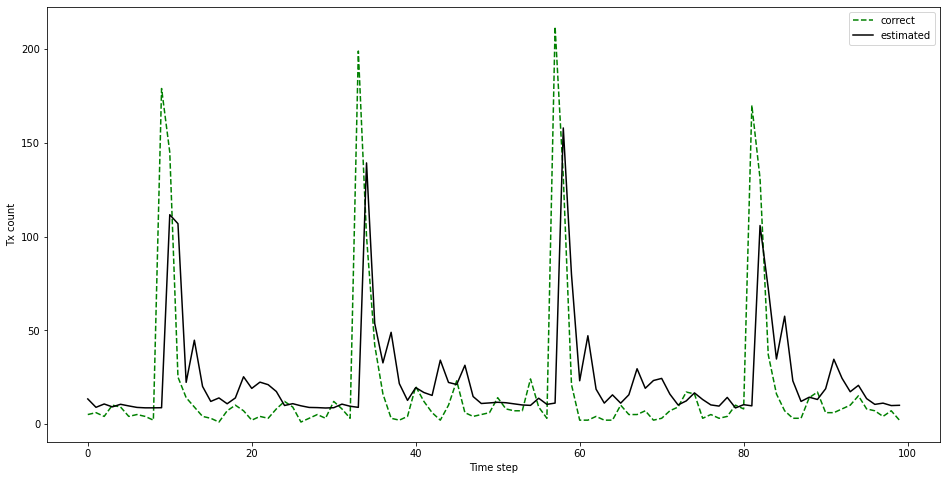

In [24]:
y_pred = est.predict(X_test)
plt.figure(figsize=(16,8))
plt.plot(y_test[-100:].values,'--g',label='correct')
plt.plot(y_pred[-100:],'k',label='estimated')
plt.ylabel("Tx count")
plt.xlabel("Time step")
_=plt.legend()

Let's train with different parameters beginning with window parameter. A larger window should give better estimates.

In [25]:
# Generate input based on window parameter
def generate_datasets(window):
    X = np.lib.stride_tricks.sliding_window_view(df_hourly.tx_count,window)
    X = np.hstack((X, df_hourly['hour'].values[window-1:].reshape(-1,1)))
    y = df_hourly.tx_count.shift(-1)[window-1:]
    X = X[:-1,:]
    y = y[:-1]
    X_train = X[6000:25000,:]
    y_train = y[6000:25000]
    X_test  = X[28001:,:]
    y_test  = y[28001:]
    
    return X_train,y_train,X_test,y_test    

window : 76 : train score 0.85 , test_score 0.69


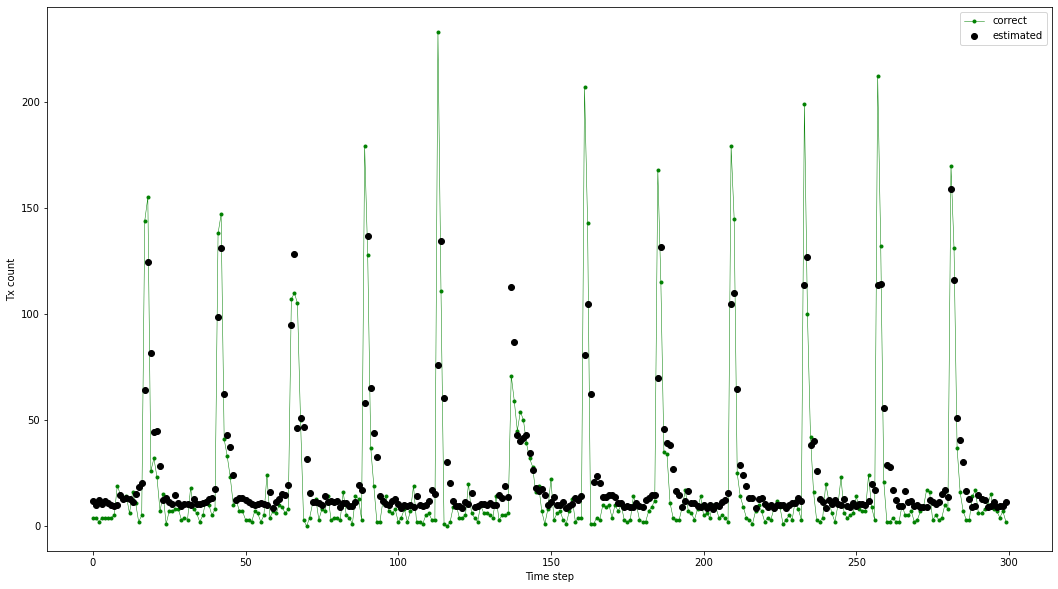

In [26]:
window = 76
X_train,y_train,X_test,y_test = generate_datasets(window)
learning_rate= 0.001
l2_reg = 0.001
val_fraction= 0.3
max_iter = 100000
est = HistGradientBoostingRegressor(learning_rate=learning_rate,
                                    validation_fraction=val_fraction,
                                    l2_regularization=l2_reg,
                                    max_iter= max_iter                                   
                                   )
est.fit(X_train,y_train)
print(f"window : {window} : train score {est.score(X_train,y_train):0.2f} , test_score {est.score(X_test,y_test):0.2f}")
y_est = est.predict(X_test)
plt.figure(figsize=(18,10))
plt.plot(y_test[-300:].values,'.-g',label='correct',linewidth=0.5)
plt.plot(y_est[-300:],'ok',label='estimated')
plt.ylabel("Tx count")
plt.xlabel("Time step")
_ = plt.legend()